In [ ]:
!pip install ../input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install ../input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install ../input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install ../input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install ../input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [ ]:
pip install git+https://github.com/ResidentMario/missingno.git

In [1]:
import pandas as pd
import numpy as np
import os

/Users/christang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/christang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [3]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer 
from sklearn.model_selection import train_test_split

In [4]:
import myutils.preprocessing as pp 
import myutils.visualization as vz
from metric import score as sc
%load_ext autoreload
%autoreload 2

In [5]:
from lifelines import KaplanMeierFitter

In [6]:
def read_data(data_dir,fileNames):
    path = os.path.join(data_dir,fileNames)
    df = pd.read_csv(path)
    return df

In [22]:
data_dir = '../input/data'
output_dir = '../output'

fName1 = 'train.csv'
fName2 = 'test.csv'
fName3 = 'data_dictionary.csv'

trainData = read_data(data_dir,fName1)
testData = read_data(data_dir,fName2)
dataDict = read_data(data_dir,fName3)

random_seed = 202501

# Data Understanding and Inspection

In [ ]:
print(trainData.head(5))

In [ ]:
print("Size of the df:",trainData.shape, "\nColumn Names:\n", trainData.columns)

In [ ]:
print("Size of the df:",testData.shape, "\nColumn Names:\n", testData.columns)

In [ ]:
print(trainData.info())

In [ ]:
vz.scatter_plot(trainData,'efs_time','efs')

In [20]:
#inspecting missing values for the training set
print(trainData.isnull().sum().sort_values(ascending=False))

tce_match                 18996
mrd_hct                   16597
cyto_score_detail         11923
tce_div_match             11396
tce_imm_match             11133
cyto_score                 8068
hla_high_res_10            7163
hla_high_res_8             5829
hla_high_res_6             5284
hla_match_dqb1_high        5199
hla_low_res_10             5064
conditioning_intensity     4789
hla_match_c_high           4620
hla_match_a_high           4301
hla_nmdp_6                 4197
hla_match_dqb1_low         4194
hla_match_b_high           4088
hla_low_res_8              3653
hla_match_drb1_high        3352
hla_low_res_6              3270
hla_match_c_low            2800
hla_match_drb1_low         2643
hla_match_b_low            2565
cardiac                    2542
peptic_ulcer               2419
hla_match_a_low            2390
arrhythmia                 2202
rheum_issue                2183
rituximab                  2148
pulm_severe                2135
diabetes                   2119
psych_di

In [9]:
#inspecting missing values for the test set
print(testData.isnull().sum().sort_values(ascending=False))

cyto_score_detail         2
conditioning_intensity    2
mrd_hct                   2
cyto_score                2
tce_match                 2
donor_age                 2
hla_high_res_10           1
tce_div_match             1
tce_imm_match             1
hla_high_res_8            1
hla_match_c_high          1
prior_tumor               0
rheum_issue               0
hla_match_b_low           0
peptic_ulcer              0
age_at_hct                0
hla_match_a_low           0
hepatic_severe            0
gvhd_proph                0
ID                        0
hla_match_b_high          0
sex_match                 0
race_group                0
comorbidity_score         0
karnofsky_score           0
hepatic_mild              0
donor_related             0
melphalan_dose            0
hla_low_res_8             0
cardiac                   0
hla_match_drb1_high       0
pulm_moderate             0
hla_match_a_high          0
year_hct                  0
in_vivo_tcd               0
obesity             

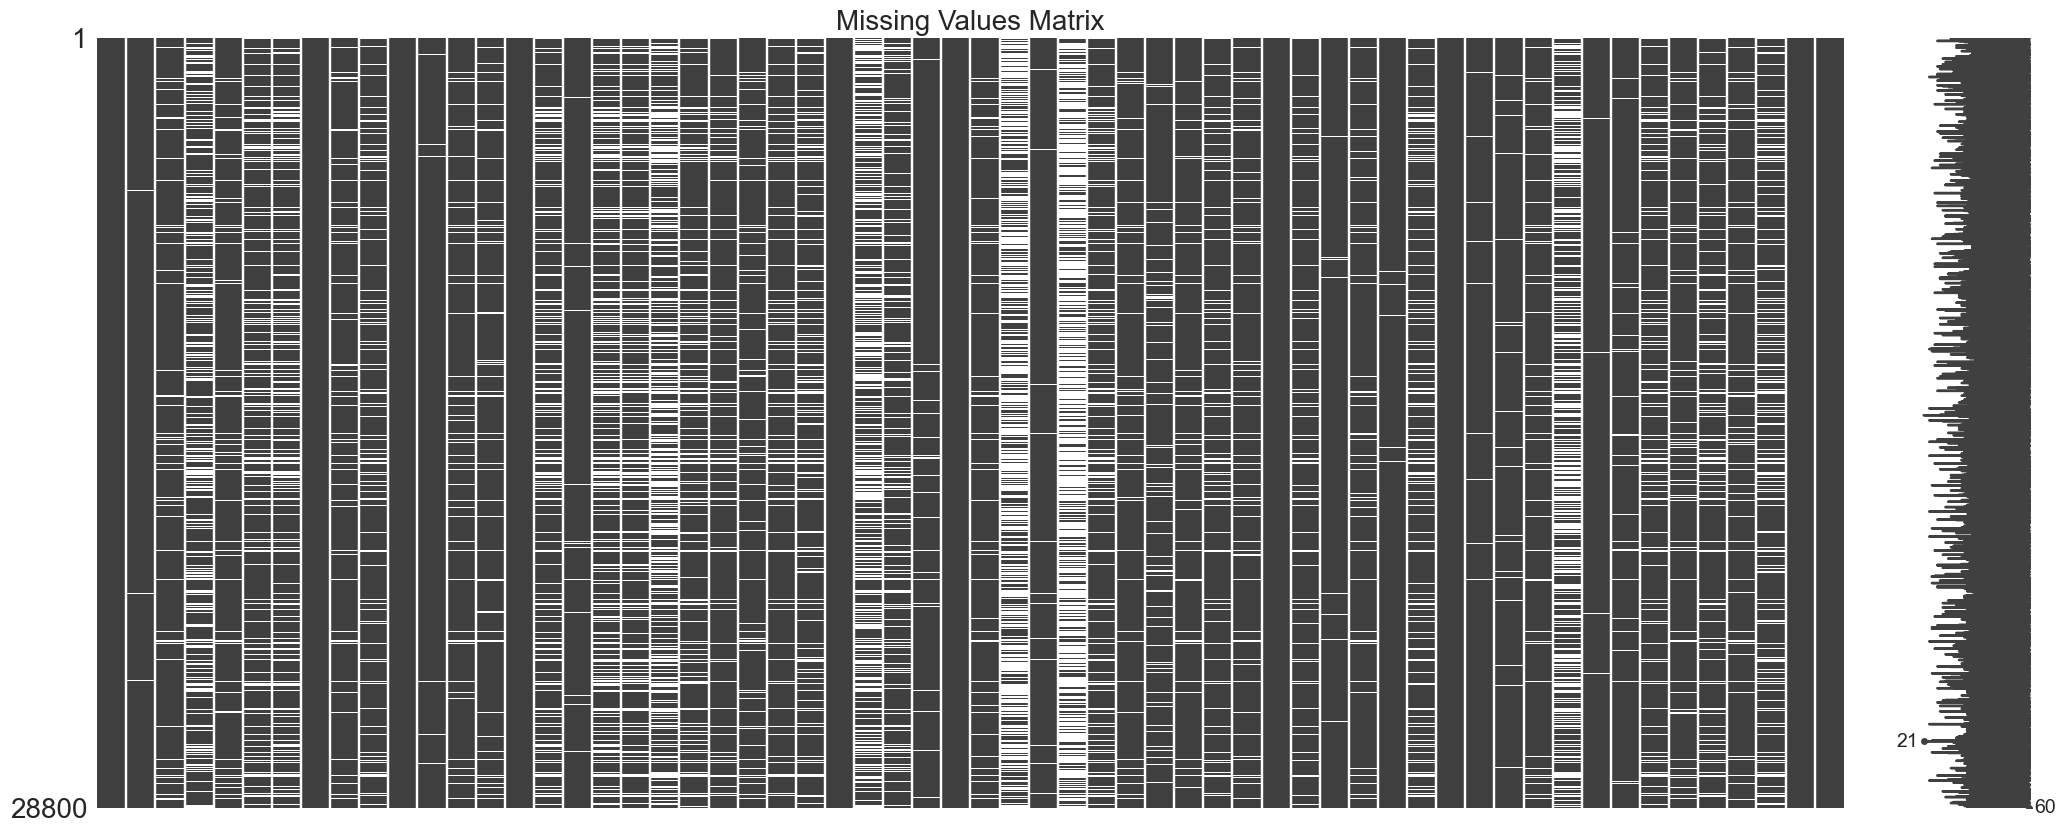

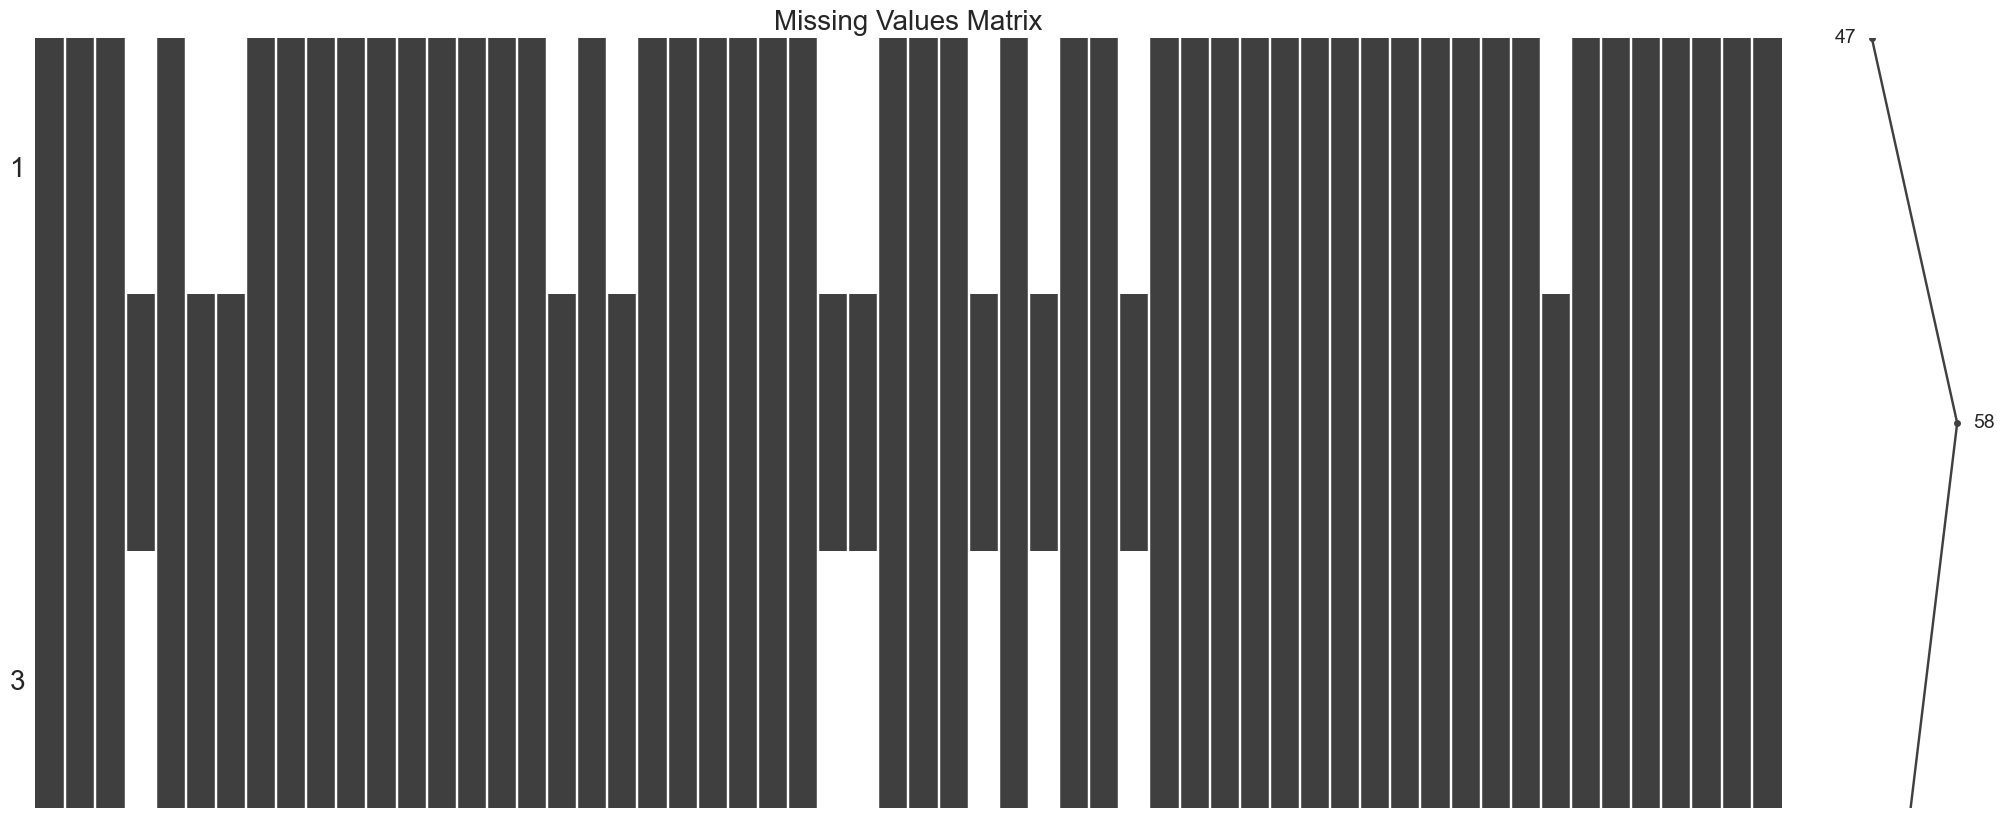

In [10]:
#plot the missing values heatmap
vz.plot_missing_values(trainData)
vz.plot_missing_values(testData)

Due to the large number of missing values and unclearness of the patterns in the values that are missing, regular imputation methods will not be considered to use as the training accuracy could be severly impaired.

In [ ]:
#Understanding the missing values


#missing_values = pp.missing_val_df(trainData)
#missing_values = missing_values.merge(dataDict[['variable', 'description']], left_on='variables', right_on='variable', how='left')
#missing_values.drop(columns=['variable'], inplace=True)
#missing_values.rename(columns={'description': 'Variable Description'}, inplace=True)

#missing_values

In [11]:
# Detect duplicate rows
#duplicate_rows = trainData[trainData.duplicated()]
# Show duplicate rows
#print(duplicate_rows)

No duplicated observations is discovered in the dataset

# Data Preprocessing

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder

In [25]:
def prepare_data(trainData, testData, target_cols, id_col='ID'):
    feature_cols = [col for col in trainData.columns if col not in target_cols + [id_col]]

    X_train = trainData[feature_cols]
    y_train = trainData[target_cols]
    X_test = testData[feature_cols]
    return X_train, y_train, X_test


target_cols = ['efs', 'efs_time']

X_train, y_train, X_test = prepare_data(trainData, testData,target_cols)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (28800, 57)
y_train shape: (28800, 2)
X_test shape: (3, 57)


In [17]:
def transform_suv_prob(df, time = 'efs_time', event = 'efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time], event_observed=df[event])
    survivals_prob = kmf.survival_function_at_times(df[time]).values
    return survivals_prob

def preprocess_data (X_train,y_train,X_test,num_cols,cat_cols,event_col = 'efs',time_col = 'efs_time'):
    X_train_copy =  X_train.copy()
    y_train_copy = y_train.copy()

    training_data = pd.concat([X_train_copy,y_train_copy],axis=1)
    training_data['y'] = transform_suv_prob(training_data,time_col,event_col)

    num_pp = Pipeline([
        ('Imputer',SimpleImputer(strategy='median')),
        ('scaler',StandardScaler()),
    ])

    cat_pp = Pipeline([
        ('imputer',SimpleImputer(strategy='constant',fill_value='UNKNOWN')),
        ('encoder',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ])

    preprocessor = ColumnTransformer(
        transformers=
        [
            ('num',num_pp,num_cols),
            ('cat',cat_pp,cat_cols)
        ]
    )

    X_train_processed = preprocessor.fit_transform(X_train_copy)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed,X_test_processed,preprocessor


    


In [26]:
# Define columns
num_cols = pp.numeric_df(X_train).columns.tolist()  # Numerical columns
cat_cols = pp.get_cat_cols(X_train)                # Categorical columns

# Apply preprocessing
X_train_processed, X_test_processed, preprocessor = preprocess_data(
    X_train, y_train, X_test, num_cols, cat_cols, time_col='efs_time', event_col='efs'
)

print(f"Processed Training Data Shape: {X_train_processed.shape}")
print(f"Processed Test Data Shape: {X_test_processed.shape}")


Processed Training Data Shape: (28800, 57)
Processed Test Data Shape: (3, 57)


In [ ]:
NUM_COLS = pp.get_num_cols(trainData)
CAT_COLS = pp.get_cat_cols(trainData)

In [ ]:
#We will perform data preprocessing on the numerical variables and categorical variables separately.

X_train_num = pp.numeric_df(X_train)
X_test_num = pp.numeric_df(X_test)

cat_colsTrain = pp.get_cat_cols(X_train)
X_train_cat = X_train[cat_colsTrain]

cat_colsTest = pp.get_cat_cols(X_test)
X_test_cat = X_test[cat_colsTest]



In [ ]:
#Plot the correlation heatmap between numerical variables to check for multicollinearity, 
#before we decide on which imputation method to use.
vz.cor_heatmap(X_train_num)

As we can see, the variables that starts with "hla" seems to be highly correlated with on another, while the other variables do not exhibited clear correlation.
Therefore, we decided to employ KNN (similarity based) imputer on all the variables that start with "hla" and Iterative imputer for the rest of the variables.

In [ ]:
import math
n_cols = 2
n_plots = len(X_train_cat.columns)
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
axes = axes.flatten()

for i, cols in enumerate(X_train_cat.columns):
    sns.countplot(data=X_train_cat, x=cols, ax=axes[i])
    axes[i].set_title(cols)
    axes[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
import math
n_cols = 2
n_plots = len(X_test_cat.columns)
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
axes = axes.flatten()

for i, cols in enumerate(X_test_cat.columns):
    sns.countplot(data=X_test_cat, x=cols, ax=axes[i])
    axes[i].set_title(cols)
    axes[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [27]:
print(X_train.dtypes)
print(X_test.dtypes)

print(X_train.shape)
print(X_test.shape)


dri_score                  object
psych_disturb              object
cyto_score                 object
diabetes                   object
hla_match_c_high          float64
hla_high_res_8            float64
tbi_status                 object
arrhythmia                 object
hla_low_res_6             float64
graft_type                 object
vent_hist                  object
renal_issue                object
pulm_severe                object
prim_disease_hct           object
hla_high_res_6            float64
cmv_status                 object
hla_high_res_10           float64
hla_match_dqb1_high       float64
tce_imm_match              object
hla_nmdp_6                float64
hla_match_c_low           float64
rituximab                  object
hla_match_drb1_low        float64
hla_match_dqb1_low        float64
prod_type                  object
cyto_score_detail          object
conditioning_intensity     object
ethnicity                  object
year_hct                    int64
obesity       

# Modeling

In [ ]:
%pip install xgboost

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_squared_error


In [ ]:
num_folds = 10
k_folds = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

In [ ]:
for i, (train_i,test_i) in enumerate(k_folds.split(train)):
    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_i,FEATURES].copy()
    y_train = train.loc[train_i,"suv_prob"]
    x_valid = train.loc[test_i,FEATURES].copy()
    y_valid = train.loc[test_i,"suv_prob"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )
    oof_xgb[test_i] = model_xgb.predict(x_valid)
    pred_xgb += model_xgb.predict(x_test) / num_folds

pred_xgb /= num_folds

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb
m = sc(y_true.copy(), y_pred.copy(), "ID")
print(f"\nCV score of Keplan Meier XGB model =",m)

In [ ]:
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  
plt.show()